In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [2]:
cd ../

C:\Users\akite\OneDrive\デスクトップ\source code\twitter-compe


In [4]:
train_df = pd.read_csv('./data/preprosessing_train.csv')

In [5]:
X_df_train = train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_del_one"]]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
y_train = Y_df_train.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=1)


In [6]:
X_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20285 entries, 0 to 20284
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_url        20285 non-null  float64
 1   is_location   20285 non-null  float64
 2   num_emoji     20285 non-null  float64
 3   num_reply     20285 non-null  float64
 4   num_hash      20285 non-null  float64
 5   text_length   20285 non-null  float64
 6   num_kusa      20285 non-null  float64
 7   is_date       20285 non-null  float64
 8   is_time       20285 non-null  float64
 9   text_del_one  20280 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [7]:
#特徴量配列
X_train_feat = X_train[:,:8]
X_valid_feat = X_valid[:,:8]
X_train_feat.shape

(16228, 8)

In [8]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_feat_ss = ss.fit_transform(X_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)

In [12]:
#文字カラムに対する欠損値削除
X_train_del_one = X_train[:,9]
for idx in range(len(X_train_del_one)):
    if type(X_train_del_one[idx]) is float:
        X_train_del_one[idx] = " " 

X_valid_del_one = X_valid[:,9]
for idx in range(len(X_valid_del_one)):
    if type(X_valid_del_one[idx]) is float:
        X_valid_del_one[idx] = " " 

nan
nan
nan
nan
nan


In [13]:
#単語ベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer()
X_train_cv = cv.fit_transform(X_train_del_one)
X_valid_cv = cv.transform(X_valid_del_one)

In [14]:
#文字配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train_feat_ss],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid_feat_ss],1)

In [15]:
#型変換
X_train = X_train.astype(np.float64)
X_valid = X_valid.astype(np.float64)

In [16]:
#スパース配列に変換
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)
X_valid_csr = csr_matrix(X_valid)

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500,
                                    random_state=1)
model.fit(X_train_csr, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

正解率:0.9679566181907814
適合率:0.5618374558303887
再現率:0.9636363636363636
F値:0.7098214285714285
[[3768    6]
 [ 124  159]]


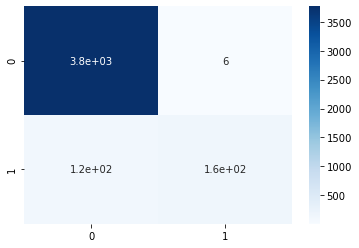

In [18]:

y_pred = model.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)

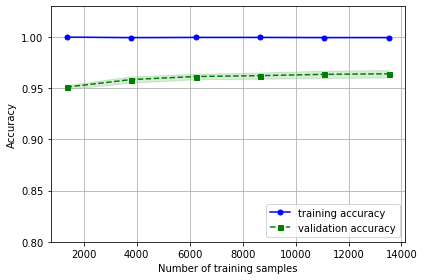

In [25]:
draw_learning_curve(X_train_csr,y_train,model,6)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    print("適合率:"+str(recall_score(Y_test,Y_pred)))
    print("再現率:"+str(precision_score(Y_test,Y_pred)))
    print("F値:"+str(f1_score(Y_test, Y_pred)))  
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
def draw_learning_curve(X_train,Y_train,pipe,cvnum):
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=pipe,
                                   X=X_train,
                                   y=Y_train,
                                   train_sizes=np.linspace(0.1, 1.0, cvnum),
                                   cv=cvnum,
                                   n_jobs=3)#0.1~1の10刻み（割合になっている）

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.03])
    plt.tight_layout()
    plt.show()